In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 28 20:09:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   48C    P0    71W / 300W |    881MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1_1e-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 255892
-rw-rw-r-- 1 scpark scpark    94591  1월 28 20:09 events.out.tfevents.1706440067.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7472764  1월 28 20:08 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 28 20:07 events.out.tfevents.1706439866.GPUSVR11
-rw-rw-r-- 1 scpark scpark 42350227  1월 28 20:01 events.out.tfevents.1706413025.GPUSVR11
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:54 save_280000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:39 save_270000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:23 save_260000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 19:08 save_250000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:52 save_240000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:37 save_230000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:21 save_220000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 18:06 save_210000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:50 save_200000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:35 save_190000
-rw-rw-r-- 1 scpark scpark  7477961  1월 28 17:19 save_

### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

9618
lse_loss -5.685317039489746
commit_loss 0.0010768247302621603
recon_loss 0.0037714135833084583
9619
lse_loss -5.698086261749268
commit_loss 0.0009633800364099443
recon_loss 0.003905625781044364
9620
lse_loss -5.679732799530029
commit_loss 0.001130800461396575
recon_loss 0.004212433937937021
9621
lse_loss -5.694466590881348
commit_loss 0.0009610452107153833
recon_loss 0.003862336277961731
9622
lse_loss -5.6688971519470215
commit_loss 0.0010846219956874847
recon_loss 0.004149896092712879
9623
lse_loss -5.627087593078613
commit_loss 0.0009855247335508466
recon_loss 0.004022796638309956
9624
lse_loss -5.684564590454102
commit_loss 0.0010017523309215903
recon_loss 0.004413362592458725
9625
lse_loss -5.68586540222168
commit_loss 0.0009905094048008323
recon_loss 0.0037288120947778225
9626
lse_loss -5.696603298187256
commit_loss 0.0008982987492345273
recon_loss 0.003949176054447889
9627
lse_loss -5.687139511108398
commit_loss 0.0009173639700748026
recon_loss 0.004021735861897469
9628
lse_

9703
lse_loss -5.682592868804932
commit_loss 0.0009217212209478021
recon_loss 0.0037407311610877514
9704
lse_loss -5.685718536376953
commit_loss 0.0008469232125207782
recon_loss 0.003407529555261135
9705
lse_loss -5.693577766418457
commit_loss 0.0009215250029228628
recon_loss 0.003954746760427952
9706
lse_loss -5.665400505065918
commit_loss 0.0010820977622643113
recon_loss 0.0044856988824903965
9707
lse_loss -5.69435977935791
commit_loss 0.0008958186954259872
recon_loss 0.004204296041280031
9708
lse_loss -5.685419082641602
commit_loss 0.0009834750089794397
recon_loss 0.003958680666983128
9709
lse_loss -5.679876327514648
commit_loss 0.0009547648369334638
recon_loss 0.004348221700638533
9710
lse_loss -5.6724958419799805
commit_loss 0.001146475551649928
recon_loss 0.0038485052064061165
9711
lse_loss -5.703180313110352
commit_loss 0.0009124659700319171
recon_loss 0.0036175851710140705
9712
lse_loss -5.691099166870117
commit_loss 0.0009698658250272274
recon_loss 0.0036781257949769497
9713
l

In [12]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


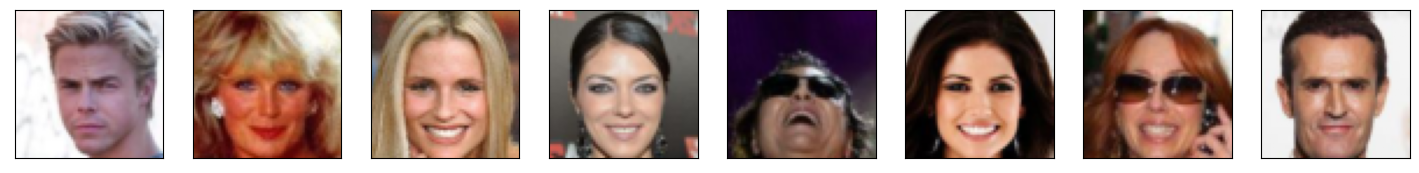

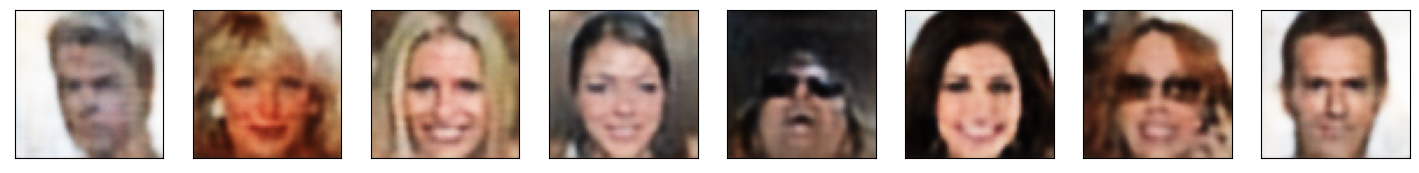

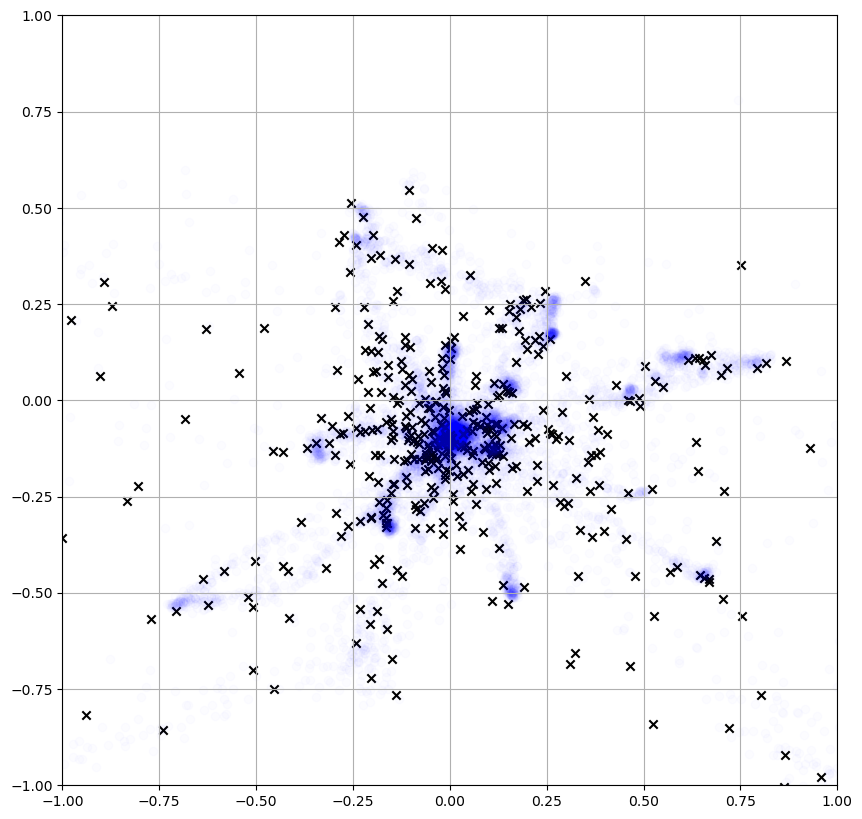

In [15]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()
plt.show() 